In [37]:
import pulp
import pandas as pd
from ortoolpy import model_min, addbinvars, addvals
from pulp import lpSum
from matplotlib.colors import ListedColormap

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    result = [x for x in result if x != -1.0]
    return result

def get_adjacent(arr, basin_num):
    neighbors = []
    rows, cols = arr.shape
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    for row in range(rows):
        for col in range(cols):
            if int(arr[row, col]) == int(basin_num):
                for dr, dc in directions:
                    r, c = row + dr, col + dc
                    if 0 <= r < rows and 0 <= c < cols:
                        if int(arr[r,c]) != int(basin_num):
                            neighbors.append(int(arr[r, c]))
                        
    unique_neighbors = get_unique_non_masked_values(neighbors)
    return unique_neighbors

def four_color_problem(Rivnum_masked_array, color_code):
    basin_lst = get_unique_non_masked_values(Rivnum_masked_array)
    
    # make data
    df = pd.DataFrame([
    (i, int(basin_lst[i]), j) 
    for i in range(len(basin_lst)) 
    for j in range(len(color_code))
    ], columns=['code', 'basin_num', 'color'])
    
    # optimization
    m = model_min()  # 数理モデル(1)
    addbinvars(df)  # 変数表(2)
    for i in range(len(basin_lst)):
        m += lpSum(df[df.code == i].Var) == 1  # 1県1色(3)
        for j in get_adjacent(Rivnum_masked_array, int(basin_lst[i])):
            for k in range(len(color_code)):  # 隣接県を違う色に(4)
                m += lpSum(df[((df.code == i)  | (df.basin_num == int(j))) & (df.color == k)].Var) <= 1
    m.solve(pulp.PULP_CBC_CMD(msg=0))  # 求解(5)
    addvals(df)  # 結果設定(6)
    cols = df[df.Val > 0].color.apply(color_code.__getitem__).reset_index(drop=True)
    return df
    
def pulp_cmap(Rivnum_masked_array, color_code):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)
    
    df = four_color_problem(Rivnum_masked_array, color_code)
    opt_df = df[df.Val>0]
    color_list = opt_df['color'].tolist()
    colors_list = [color_code[i] for i in color_list]

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

2e-44 1.06713e-40


/usr/local/lib/python3.10/dist-packages/matplotlib/image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


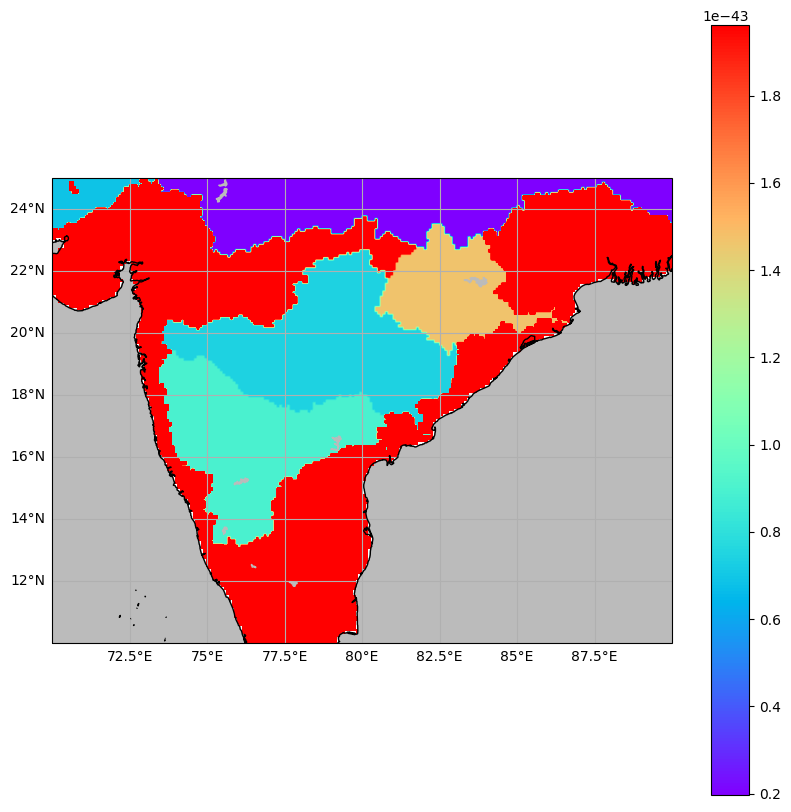

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea


path = '/mnt/c/Users/tsimk/Downloads/research/H08/CaMa/glb_05min/basin.bin'
rivnum = np.fromfile(path, dtype='float32').reshape(2160, 4320)

left, right, bottom, top =  70, 90, 10, 25

resolution = 12
nx, ny = (right - left)*resolution, (top - bottom)*resolution 
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution

rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
mask = np.isnan(rivnum_cropped)
rivnum_cropped[mask] = -9999
rivnum_masked = np.ma.masked_where(rivnum_cropped == -9999, rivnum_cropped)
print(np.min(rivnum_masked), np.max(rivnum_masked))

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
projection = ccrs.PlateCarree()
ax.set_extent(img_extent, projection)
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.top_labels = False   
gl.right_labels = False 
ax.add_feature(cfea.OCEAN, color='#BBBBBB')
ax.add_feature(cfea.LAKES, color='#BBBBBB')
ax.coastlines(zorder=1)
img = ax.imshow(rivnum_masked,
                origin='upper',
                extent=img_extent,
                transform=projection,
                cmap='rainbow',
                vmin=np.min(rivnum_masked), vmax = np.min(rivnum_masked)*10
               )
fig.colorbar(img, ax=ax)
plt.show()

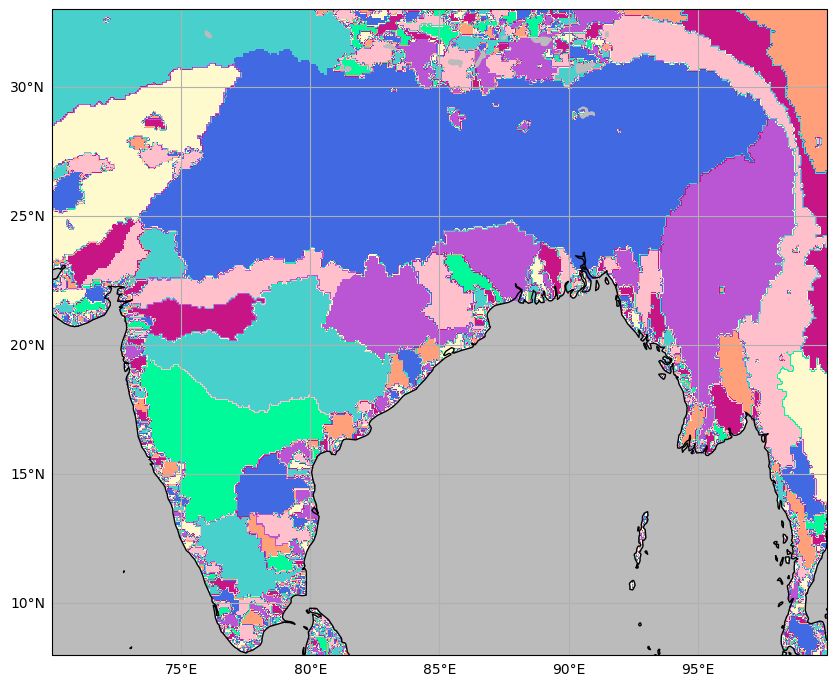

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea


path = '/mnt/c/Users/tsimk/Downloads/research/h08/cama/glb_05min/basin.bin'
rivnum = np.fromfile(path, dtype='float32').reshape(2160, 4320)
left, right, bottom, top =  70, 100, 8, 33

resolution = 12
nx, ny = (right - left)*resolution, (top - bottom)*resolution 
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution

rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
mask = np.isnan(rivnum_cropped)
rivnum_cropped[mask] = -9999
rivnum_masked = np.ma.masked_where(rivnum_cropped == -9999, rivnum_cropped)
rivnum_masked = rivnum_masked*1e44

color_code = ['#4169e1', '#fffacd', '#c71585', '#00fa9a', '#ba55d3', '#48d1cc', '#ffc0cb', '#ffa07a']
color_filled = rivnum_masked.filled(-1)
num_colors, index_dict, cmap = pulp_cmap(color_filled, color_code)

indexed_data = np.vectorize(get_index)(color_filled, index_dict)
indexed_data_masked = np.ma.masked_where(indexed_data<0, indexed_data)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
projection = ccrs.PlateCarree()
ax.set_extent(img_extent, projection)
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.top_labels = False   
gl.right_labels = False 
ax.add_feature(cfea.OCEAN, color='#bbbbbb')
ax.add_feature(cfea.LAKES, color='#bbbbbb')
ax.coastlines(zorder=1)
img = ax.imshow(indexed_data_masked,
                origin='upper',
                extent=img_extent,
                transform=projection,
                cmap=cmap,
                
               )
plt.show()


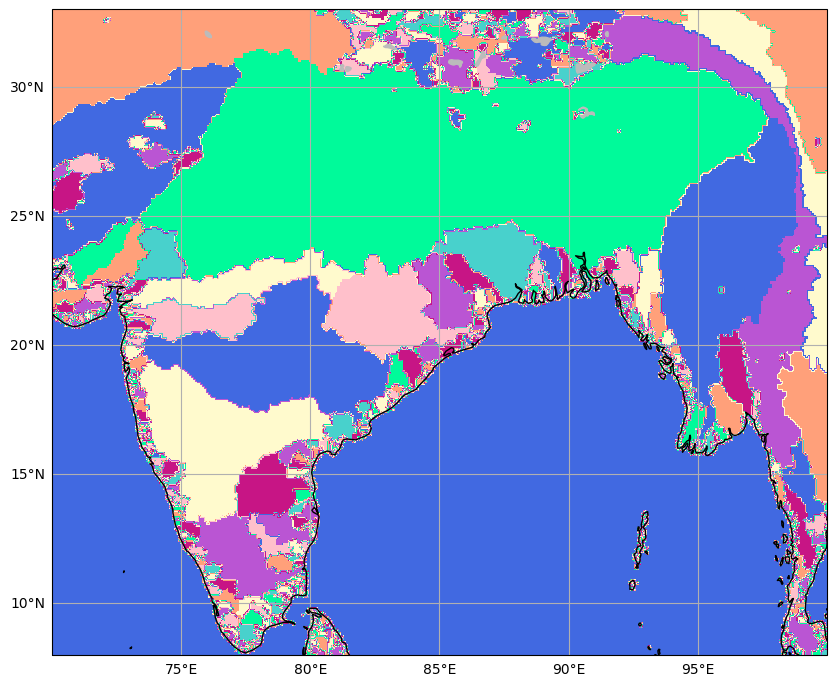

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea


path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivnum = np.fromfile(path, dtype='float32').reshape(2160, 4320)
left, right, bottom, top =  70, 100, 8, 33

resolution = 12
nx, ny = (right - left)*resolution, (top - bottom)*resolution 
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution

rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
color_code = ['#4169e1', '#fffacd', '#c71585', '#00fa9a', '#ba55d3', '#48d1cc', '#ffc0cb', '#ffa07a']
color_masked = np.ma.masked_where(rivnum_cropped >= 1e20, rivnum_cropped)
color_filled = color_masked.filled(-1)
num_colors, index_dict, cmap = pulp_cmap(color_filled, color_code)

# data
data_masked = np.ma.masked_where(rivnum_cropped >= 1e20, rivnum_cropped)
data_filled = data_masked.filled(-1)
indexed_data = np.vectorize(get_index)(data_filled, index_dict)
indexed_data_masked = np.ma.masked_where(indexed_data<0, indexed_data)

fig = plt.figure(figsize=(10, 10))
projection = ccrs.PlateCarree()
ax = plt.subplot(projection=projection)
ax.set_extent(img_extent, projection)
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.top_labels = False   
gl.right_labels = False 
ax.add_feature(cfea.OCEAN, color='#bbbbbb')
ax.add_feature(cfea.LAKES, color='#bbbbbb')
ax.coastlines(zorder=1)
img = ax.imshow(indexed_data_masked,
                origin='upper',
                extent=img_extent,
                transform=projection,
                cmap=cmap,
                
               )
plt.show()